In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Load the business demand data
BD = pd.read_csv("Business_demand_trends_20240901140306.csv")

# Remove the first 9 rows
BD = BD.iloc[9:].reset_index(drop=True)

# Convert 'Period start' to datetime format
BD['Period start'] = pd.to_datetime(BD['Period start'], format='%d/%m/%y')

# Filter for Central North Island (CNI) region
region_description = "Central North Island"

# Filter for the specific "Region description"
BD_region = BD[BD['Region description'] == region_description]

# Split into training and validation sets by '2021-01-01'
split_date = '2021-01-01'
train_BD = BD_region[BD_region['Period start'] < split_date]
validation_BD = BD_region[BD_region['Period start'] >= split_date]

# Set 'Period start' as the index
train_BD.set_index('Period start', inplace=True)
validation_BD.set_index('Period start', inplace=True)

# Select 'Selected business demand (GWh)' as the target variable for analysis
y_train = train_BD['Selected business demand (GWh)']
y_validation = validation_BD['Selected business demand (GWh)']

# Apply 1st order regular differencing (to remove trend)
y_train_diff = y_train.diff().dropna()

# Apply seasonal differencing (assuming monthly data, so period=12)
y_train_diff_seasonal = y_train_diff.diff(12).dropna()

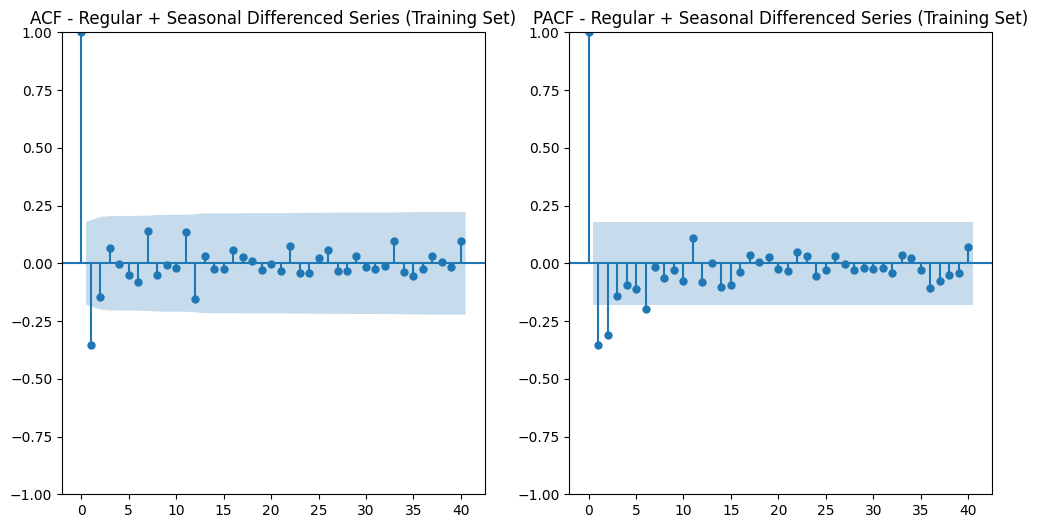

In [3]:
# Plot ACF and PACF for the series after regular and seasonal differencing
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(y_train_diff_seasonal, lags=40, ax=plt.gca())
plt.title('ACF - Regular + Seasonal Differenced Series (Training Set)')

plt.subplot(122)
plot_pacf(y_train_diff_seasonal, lags=40, ax=plt.gca())
plt.title('PACF - Regular + Seasonal Differenced Series (Training Set)')

plt.show()

In [4]:
# Based on the ACF and PACF interpretation, we are building two SARIMA models: 
# 1. AR term focused model 
# 2. MA term focused model 

##########################
# Model 1: AR Term Focused
##########################
# SARIMA model with AR terms (3, 1, 0)x(0, 1, 0, 12)
sarima_model_1 = SARIMAX(y_train, order=(3, 1, 0), seasonal_order=(0, 1, 0, 12))
results_1 = sarima_model_1.fit()

# Forecast using Model 1
forecast_1 = results_1.forecast(steps=len(y_validation))

# Print the summary of Model 1
print(results_1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91179D+00    |proj g|=  2.30812D-03

At iterate    5    f=  3.91178D+00    |proj g|=  1.83278D-03

At iterate   10    f=  3.91176D+00    |proj g|=  1.80377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   4.335D-06   3.912D+00
  F =   3.9117627009092883     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [5]:
##########################
# Model 2: MA Term Focused
##########################
# SARIMA model with MA terms (0, 1, 2)x(0, 1, 0, 12)
sarima_model_2 = SARIMAX(y_train, order=(0, 1, 2), seasonal_order=(0, 1, 0, 12))
results_2 = sarima_model_2.fit()

# Forecast using Model 2
forecast_2 = results_2.forecast(steps=len(y_validation))

# Print the summary of Model 2
print(results_2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89190D+00    |proj g|=  2.01028D-02

At iterate    5    f=  3.88964D+00    |proj g|=  5.36926D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   3.886D-07   3.889D+00
  F =   3.8892221350570906     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:      Selected business de

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [6]:
######################
# Auto ARIMA Model
######################
# Perform Auto ARIMA to automatically search for the best SARIMA model
auto_arima_model = pm.auto_arima(y_train, 
                                 seasonal=True, 
                                 m=12,  # Monthly seasonality
                                 d=1, D=1,  # Regular and seasonal differencing
                                 start_p=0, max_p=5,  # Start AR terms
                                 start_q=0, max_q=5,  # Start MA terms
                                 start_P=0, max_P=4,  # Start seasonal AR terms
                                 start_Q=0, max_Q=4,  # Start seasonal MA terms
                                 stepwise=False,  # Perform exhaustive search
                                 trace=False,  # Display search progress
                                 error_action='ignore', 
                                 suppress_warnings=True)

# Display the selected model summary
print(auto_arima_model.summary())

# Forecast using Auto ARIMA model
forecast_auto_arima = auto_arima_model.predict(n_periods=len(y_validation))

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -505.756
Date:                              Fri, 04 Oct 2024   AIC                           1019.513
Time:                                      12:20:18   BIC                           1030.629
Sample:                                  01-01-2010   HQIC                          1024.027
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5774      0.048    -12.020      0.000      -0.672      -0.483
ma.L2         -0.19

In [7]:
######################
# Evaluation of Models
######################
# Function to calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAE, RMSE, MAPE for Model 1 (AR terms)
mae_1 = mean_absolute_error(y_validation, forecast_1)
rmse_1 = np.sqrt(mean_squared_error(y_validation, forecast_1))
mape_1 = mape(y_validation, forecast_1)

# Calculate MAE, RMSE, MAPE for Model 2 (MA terms)
mae_2 = mean_absolute_error(y_validation, forecast_2)
rmse_2 = np.sqrt(mean_squared_error(y_validation, forecast_2))
mape_2 = mape(y_validation, forecast_2)

# Calculate MAE, RMSE, MAPE for Auto ARIMA model
mae_auto = mean_absolute_error(y_validation, forecast_auto_arima)
rmse_auto = np.sqrt(mean_squared_error(y_validation, forecast_auto_arima))
mape_auto = mape(y_validation, forecast_auto_arima)

# Print the evaluation results
print(f"Model 1 (AR terms) - MAE: {mae_1}, RMSE: {rmse_1}, MAPE: {mape_1}")
print(f"Model 2 (MA terms) - MAE: {mae_2}, RMSE: {rmse_2}, MAPE: {mape_2}")
print(f"Auto ARIMA Model - MAE: {mae_auto}, RMSE: {rmse_auto}, MAPE: {mape_auto}")

Model 1 (AR terms) - MAE: 27.984493549718405, RMSE: 46.28106574886981, MAPE: 6.411552552326795
Model 2 (MA terms) - MAE: 27.46086772562236, RMSE: 47.06902143004549, MAPE: 6.268172300875988
Auto ARIMA Model - MAE: 23.19462041270322, RMSE: 28.329552677541038, MAPE: 5.4307895393310455


In [14]:
# Create a DataFrame to store the predictions along with the corresponding dates
prediction_df = pd.DataFrame({
    'Date': y_validation.index,  # The dates of the validation set
    'Selected business demand (GWh)': forecast_auto_arima  # Predicted values from Model auto
})

# Ensure the 'Date' is in the format "YYYY-MM-DD"
#prediction_df['Date'] = prediction_df['Date'].dt.strftime('%Y-%m-%d')

# Output the DataFrame to a CSV file
output_file = "SARIMA,CNI,bus.csv"
prediction_df.to_csv(output_file, index=False)

In [15]:
# Filter pre-COVID data (2018 and 2019) from the dataset
pre_covid_data = BD_region[(BD_region['Period start'] >= '2018-01-01') & 
                           (BD_region['Period start'] <= '2019-12-31')]

# Set 'Period start' as the index
pre_covid_data.set_index('Period start', inplace=True)

# Initialize lists to store backtesting results
backtest_dates = []
actuals = []
predictions = []
mae_scores = []
rmse_scores = []
mape_scores = []

In [16]:
# Define a backtest function for rolling predictions
def backtest_sarima(data, window=12):
    for i in range(len(data) - window):
        # Define train and test sets
        train = data.iloc[:i + window]
        test = data.iloc[i + window:i + window + 1]

        # Define SARIMA model with the same parameters as AutoARIMA Model
        sarima_model = SARIMAX(train, order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
        results = sarima_model.fit(disp=False)

        # Forecast for the next period
        forecast = results.forecast(steps=1)
        
        # Append results
        backtest_dates.append(test.index[0])
        actuals.append(test.values[0])
        predictions.append(forecast.values[0])
        
        # Calculate error metrics
        mae_scores.append(mean_absolute_error(test, forecast))
        rmse_scores.append(np.sqrt(mean_squared_error(test, forecast)))
        mape_scores.append(np.mean(np.abs((test.values - forecast.values) / test.values)) * 100)

In [18]:
# Conduct backtesting
backtest_sarima(pre_covid_data['Selected business demand (GWh)'])

/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/richardpeng/anaconda3/envs/Richard/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parame

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed